In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

#keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten,Dropout,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle

In [2]:
base_dir = 'MRI Images'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')


print(f"Looking for training data in: {os.path.abspath(train_dir)}")
print(f"Found labels: {os.listdir(train_dir)}")

train_paths=[]
train_labels=[]


for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths, train_labels=shuffle(train_paths,train_labels) 


test_paths=[]
test_labels=[]


for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)
print(test_paths)
print(train_paths)
test_paths, test_labels=shuffle(test_paths,test_labels) 
       


Looking for training data in: c:\Users\sriti\OneDrive\Desktop\ML Projects\Brain Tumor Detection\MRI Images\Training
Found labels: ['glioma', 'meningioma', 'notumor', 'pituitary']
['MRI Images\\Testing\\glioma\\Te-glTr_0000.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0001.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0002.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0003.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0004.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0005.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0006.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0007.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0008.jpg', 'MRI Images\\Testing\\glioma\\Te-glTr_0009.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0010.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0011.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0012.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0013.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0014.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0015.jpg', 'MRI Images\\Testing\\glioma\\Te-gl_0016.jpg', '

Data Visualization

In [3]:
import random
import matplotlib.pyplot as plt

In [4]:
unique_labels = os.listdir(train_dir)
print(f"Global labels created: {unique_labels}")

Global labels created: ['glioma', 'meningioma', 'notumor', 'pituitary']


Image Preprocessing(Helper Functions)

In [5]:
#Image Augmentation Function
def augment_image(image):
    image=Image.fromarray(np.uint8(image))
    image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image=np.array(image)/255.0
    return image

#load images and apply augmentation
def open_images(paths):
    images=[]
    for path in paths:
        # 1. This loads the image as a PIL 'Image' object
        img = load_img(path, target_size=(128, 128))
        
        # 2. Convert the PIL 'Image' to a NumPy array
        img_array = img_to_array(img)
        
        # 3. Now pass the NumPy array to your augmentation function
        img_augmented = augment_image(img_array)
        
        images.append(img_augmented)
        
    return np.array(images)

#Encoder labels (Convert label names to integers)
def encoded_label(labels):
    # This now loops over the BATCH 'labels'
    encoded=[unique_labels.index(label) for label in labels]
    return np.array(encoded)
    

#Data generator for batching
def datagen(paths,labels,batch_size=12,epochs=1):
    for _  in range(epochs):
        for i in range(0,len(paths),batch_size):
            batch_paths=paths[i:i+batch_size]
            batch_images=open_images(batch_paths)
            batch_labels=labels[i:i+batch_size]
            batch_labels=encoded_label(batch_labels)
            yield batch_images, batch_labels


            


In [6]:
#Model Architecture (128,128,3)
IMAGE_SIZE=128
base_model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')

#Freeze alllayers  of VGG16 Base model
for layer in base_model.layers:
    layer.trainable=False

#Set only the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable= True   
base_model.layers[-4].trainable=True

#Create a sequential model
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten()) 
model.add(Dropout(0.3))

model.add(Dense(128,activation='relu'))#Dense Layer
model.add(Dropout(0.2))#Dropout Layer

model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])


#Parameter
batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=5

#train model
history=model.fit(datagen(train_paths,train_labels,batch_size=batch_size,epochs=epochs)
                  ,steps_per_epoch=steps)



285/285 ━━━━━━━━━━━━━━━━━━━━ 783s 3s/step - loss: 0.4291 - sparse_categorical_accuracy: 0.8325


In [7]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np


test_images=open_images(test_paths)
test_labels_encoded=encoded_label(test_labels)
test_predictions=model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded,np.argmax(test_predictions,axis=1)))




41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       300
           1       0.92      0.51      0.66       306
           2       0.92      0.98      0.95       405
           3       0.77      0.99      0.87       300

    accuracy                           0.85      1311
   macro avg       0.86      0.85      0.83      1311
weighted avg       0.87      0.85      0.84      1311



Confusion Matrix:
[[271  11   4  14]
 [ 46 157  31  72]
 [  7   0 396   2]
 [  1   2   1 296]]


<Axes: >

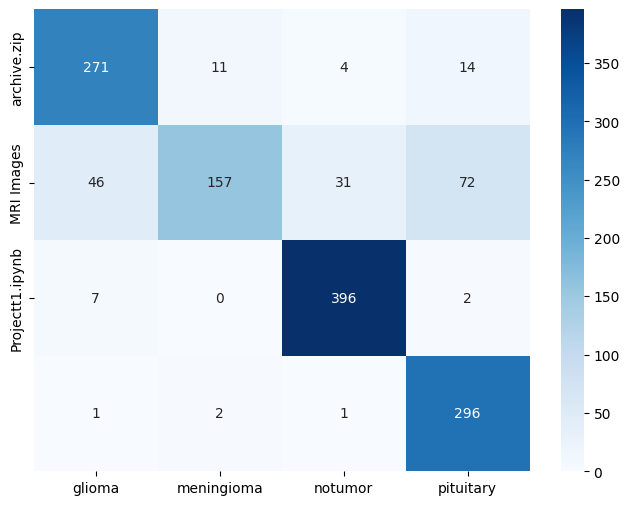

In [9]:
conf_matrix=confusion_matrix(test_labels_encoded,np.argmax(test_predictions,axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=os.listdir(train_dir),yticklabels=os.listdir())


ROC and confusion matrix

In [10]:
#Save the entire model

model.save('model.h5')


In [23]:
from tensorflow.keras.models import load_model
#Load the trained model
model=load_model('model.h5')



MRI Tumor Detection System

In [22]:
from keras.preprocessing.image import load_img , img_to_array
def detect_and_display(image_path,model):
    pass

image_path='/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'
detect_and_display(image_path,model)


In [34]:
from keras.preprocessing.image import load_img , img_to_array

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path,model):
    try:
        #load image
        img= load_img(image_path,target_size=(128,128))
        img_array=img_to_array(img)
        img_array = img_array / 255.0
        img_array=np.expand_dims(img_array,axis=0)

        #prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]


        if class_labels[predicted_class_index]=='notumor':
            return"No Tumor Detected"
        else:
            result=f"Tumor:{class_labels[predicted_class_index]}"
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()    
    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


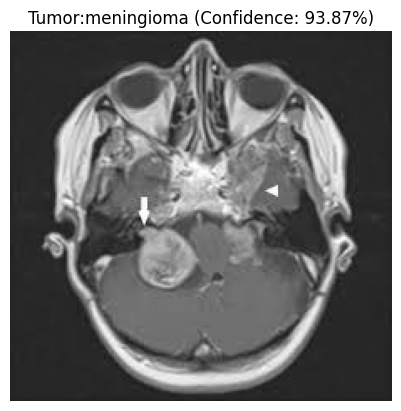

In [35]:
image_path = 'MRI Images/Testing/meningioma/Te-meTr_0002.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)